<a href="https://colab.research.google.com/github/YUCAVALCANTE/ML_Studies/blob/main/CLASSIFICA%C3%87%C3%83O_MULTICLASSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação Multiclasse — Caderno de Estudos

Antes de qualquer coisa, este notebook **não trata de decisões binárias** (“sim/não”).

Ele é sobre **classificação multiclasse**: escolher **entre várias categorias possíveis**  
(neste caso, níveis de obesidade).

Isso muda completamente a forma de pensar o problema.

Não estamos apenas prevendo um rótulo,
estamos aprendendo **fronteiras** que separam
**diferentes regiões do espaço de features**.

Cada decisão ao longo do código — pré-processamento,
estratégia de classificação, métricas —
existe para apoiar esse objetivo.

Este notebook deve ser lido como um **caderno de estudos**:
o código não é um fim,
é uma forma de organizar o pensamento.


## 0) Setup do ambiente e dependências

Em ambientes como Jupyter ou Colab, eu gosto de **congelar versões**
quando estou estudando.

Não porque seja obrigatório,
mas porque aprendizado depende de **repetição** —
e repetição depende de **reprodutibilidade**.

Se eu não fixo versões, posso achar que “errei”
quando, na verdade, **só mudou uma API**.

Isso é especialmente importante quando o objetivo
não é apenas rodar o código,
mas **entender por que ele funciona**.

A instalação em si vem na próxima célula,
separando raciocínio (aqui) de execução (lá).


In [8]:
!pip install --upgrade pip
!pip install numpy pandas scikit-learn==1.6.0 matplotlib==3.9.3 seaborn==0.13.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [10]:
# =============================================================================
# FIX DO AMBIENTE (COLAB/JUPYTER) — PANDAS QUEBRADO / EXTENSÕES C
# =============================================================================
#
# Se você está vendo:
#   "No module named 'pandas.compat'"
#   "C extension ... not built"
#
# então seu pandas instalado está quebrado/incompatível com Python 3.12.
# A correção é forçar reinstalação de wheels compatíveis (sem build local).
#
# IMPORTANTE:
# - Rode esta célula
# - Reinicie o runtime
# - Só então rode as células de imports/modelo
# =============================================================================

!pip install --upgrade pip -q
!pip install --upgrade --force-reinstall --no-cache-dir numpy pandas -q

# opcional: garantir versões do restante do stack (pode manter fixo)
!pip install --upgrade --force-reinstall --no-cache-dir scikit-learn==1.6.0 matplotlib==3.9.3 seaborn==0.13.2 -q

print("✅ Reinstalação concluída. Agora reinicie o runtime e rode os imports.")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.4.0 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.4.0 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

## 1) Importação das bibliotecas fundamentais

Imports não são um detalhe técnico.
Eles definem **o vocabulário do raciocínio**.

Aqui eu estou declarando:
- como vou representar dados
- como vou enxergar padrões
- como vou treinar e avaliar modelos

Se uma biblioteca não aparece aqui,
ela também não faz parte do meu modelo mental.


In [1]:
# -----------------------------
# NumPy
# -----------------------------
# Base para computação numérica.
# Em Machine Learning, quase tudo vira array NumPy.
import numpy as np


# -----------------------------
# Pandas
# -----------------------------
# Manipulação de dados tabulares (DataFrames).
import pandas as pd


# -----------------------------
# Visualização
# -----------------------------
# Matplotlib: base
# Seaborn: camada estatística
import matplotlib.pyplot as plt
import seaborn as sns


# -----------------------------
# Separação treino / teste
# -----------------------------
# Evita avaliar o modelo com dados que ele já viu.
from sklearn.model_selection import train_test_split


# -----------------------------
# Pré-processamento
# -----------------------------
# Padronização e codificação de variáveis
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# -----------------------------
# Modelos
# -----------------------------
# Regressão Logística e estratégia multiclasse
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier


# -----------------------------
# Métricas
# -----------------------------
from sklearn.metrics import accuracy_score


# -----------------------------
# Controle de warnings
# -----------------------------
# Em caderno de estudos, ruído atrapalha.
import warnings
warnings.filterwarnings("ignore")


## 2) Carregamento dos dados

Todo modelo aprende **apenas a partir dos dados que recebe**.

O dataset não é “o mundo”,
é uma **fotografia imperfeita** dele.

Se os dados mudam,
o que o modelo aprende como verdade também muda.

Por isso, antes de modelar,
é essencial **olhar** para os dados.


In [2]:
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv"

data = pd.read_csv(file_path)
data.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## 3) Distribuição da variável alvo

Antes de qualquer modelo,
eu preciso entender **o que estou tentando prever**.

Em classificação multiclasse,
desbalanceamento pode enganar facilmente:
um modelo pode parecer bom
apenas por acertar sempre a classe dominante.

Visualizar a distribuição do target
é um passo simples,
mas conceitualmente essencial.


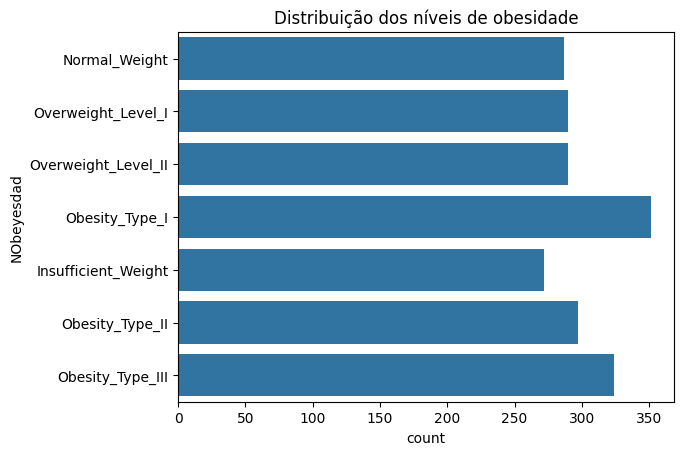

In [3]:
sns.countplot(y='NObeyesdad', data=data)
plt.title('Distribuição dos níveis de obesidade')
plt.show()


## 4) Estrutura e estatística básica do dataset

Aqui eu faço um “check de sanidade”:

- Tipos das variáveis
- Valores ausentes
- Escalas e dispersões

Pré-processamento **depende do tipo da variável**.
Se eu não entendo os dtypes,
posso aplicar transformações erradas sem perceber.


In [4]:
data.info()
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


## 5) Padronização das variáveis numéricas contínuas

Modelos baseados em gradiente, como a Regressão Logística,
**sentem a escala** das variáveis.

Se uma feature varia entre 0 e 1
e outra entre 0 e 100.000,
a segunda domina o processo de otimização.

Padronizar não “melhora” os dados,
mas coloca todas as variáveis no **mesmo campo de jogo**.

Aqui, a decisão é padronizar apenas colunas `float`,
assumindo que elas representam grandezas contínuas.
Essa é uma hipótese — não uma verdade absoluta.


In [5]:
continuous_columns = data.select_dtypes(include=['float64']).columns.tolist()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[continuous_columns])

scaled_df = pd.DataFrame(
    scaled_features,
    columns=scaler.get_feature_names_out(continuous_columns)
)

scaled_data = pd.concat(
    [data.drop(columns=continuous_columns), scaled_df],
    axis=1
)


## 6) One-Hot Encoding das variáveis categóricas

Modelos lineares não entendem texto.
Eles operam em geometria.

Ao aplicar One-Hot Encoding:
- cada categoria vira uma dimensão
- categorias não têm ordem implícita
- o modelo aprende pesos para cada uma

O `drop='first'` evita multicolinearidade perfeita
(dummy variable trap),
o que ajuda na estabilidade do modelo.


In [6]:
categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_data[categorical_columns])

encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(categorical_columns)
)

prepped_data = pd.concat(
    [scaled_data.drop(columns=categorical_columns), encoded_df],
    axis=1
)


## 7) Codificação da variável alvo

O modelo não trabalha com rótulos textuais,
apenas com números.

Aqui, a variável alvo é convertida para códigos numéricos.
Esses números **não representam ordem ou magnitude** —
são apenas identificadores.

Isso é importante:
o modelo não sabe que uma classe é “mais obesa” que outra,
apenas que são categorias diferentes.


In [7]:
prepped_data['NObeyesdad'] = (
    prepped_data['NObeyesdad']
    .astype('category')
    .cat.codes
)

prepped_data.head()


,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## 8) Separação entre treino e teste

Esse é um dos passos mais importantes do pipeline.

Separar treino e teste não é detalhe técnico,
é uma forma de **proteger a honestidade da avaliação**.

Sem essa separação,
o modelo pode parecer excelente
apenas porque está sendo avaliado
nos mesmos dados que usou para aprender.


In [8]:
X = prepped_data.drop(columns=['NObeyesdad'])
y = prepped_data['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


## 9) Modelo 1 — One-vs-All (OvA)

Na estratégia One-vs-All,
o problema multiclasse é quebrado em vários problemas binários.

Para cada classe, o modelo aprende:
“é essa classe ou não é?”

Depois, a classe com maior confiança é escolhida.

Essa abordagem é simples,
eficiente
e funciona bem quando cada classe
se separa razoavelmente do restante.


In [9]:
model_ova = LogisticRegression(
    multi_class='ovr',
    max_iter=1000
)

model_ova.fit(X_train, y_train)

y_pred_ova = model_ova.predict(X_test)


## 10) Avaliação do modelo OvA

Acurácia é um primeiro termômetro.
Ela responde:
“com que frequência o modelo acerta?”

Mas ela não diz:
- quais classes estão sendo confundidas
- onde o modelo erra mais

Mesmo assim, como ponto inicial,
ela é útil para validar se o modelo faz sentido.


In [10]:
acc_ova = accuracy_score(y_test, y_pred_ova)
print(f"OvA Accuracy: {acc_ova:.4f}")


OvA Accuracy: 0.7447


## 11) Modelo 2 — One-vs-One (OvO)

Na estratégia One-vs-One,
o modelo aprende classificadores para **cada par de classes**.

Em vez de “uma contra o resto”,
temos “uma contra uma”.

Isso costuma capturar melhor
diferenças sutis entre classes parecidas,
ao custo de maior complexidade computacional.


In [12]:
model_ovo = OneVsOneClassifier(
    LogisticRegression(max_iter=1000)
)

model_ovo.fit(X_train, y_train)

y_pred_ovo = model_ovo.predict(X_test)


## 12) Avaliação do modelo OvO

Aqui usamos a mesma métrica
para comparar estratégias diferentes.

O objetivo não é “ganhar na acurácia”,
mas entender:
qual estratégia parece mais adequada
para a geometria desse problema?


In [13]:
acc_ovo = accuracy_score(y_test, y_pred_ovo)
print(f"OvO Accuracy: {acc_ovo:.4f}")


OvO Accuracy: 0.9338


## 13) Comparação entre OvA e OvO

Essa comparação não é sobre “qual é melhor” em abstrato.

Ela serve para refletir:
- as classes se separam melhor contra o resto?
- ou os conflitos são mais locais, par a par?

O modelo não substitui o pensamento.
Ele força perguntas melhores.


In [14]:
if acc_ovo > acc_ova:
    print("OvO teve desempenho superior — conflitos locais entre classes parecem relevantes.")
elif acc_ova > acc_ovo:
    print("OvA teve desempenho superior — classes se separam bem contra o restante.")
else:
    print("Desempenhos equivalentes — vale investigar métricas por classe.")


OvO teve desempenho superior — conflitos locais entre classes parecem relevantes.


## Conclusão — o código como ferramenta de pensamento

Este notebook não existe apenas para gerar um modelo.

Ele existe para:
- tornar explícitas decisões implícitas
- conectar teoria, dados e prática
- transformar código em raciocínio estruturado

Modelos podem ser trocados.
Métricas podem mudar.
Mas a forma de pensar o problema
é o que realmente permanece.
